# Model Behavior
Apply logistic regression. Predict memory recall given alpha, gamma, and exponent changes on a single trial basis.

## Set-up

### Imports

In [1]:
# Imports - standard
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import ttest_1samp, zscore, linregress
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.metrics import accuracy_score


In [2]:
# Imports - custom
import sys
sys.path.append("../code")
from paths import PROJECT_PATH
from info import PATIENTS
from settings import COLORS

### Settings

In [3]:
# set plotting style
plt.style.use("../mplstyle/default.mplstyle")

### Functions

In [4]:
# Ordinal logistic regression helper func

def run_ordered_logit(results, features_x, feature_y):
    """
    Run ordered logistic regression to predict behavior (confidence rating)
    from spectral parameters, for a given subject/channel/material.

    Parameters
    ----------
    results : pandas DataFrame
        Dataframe containing spectral parameters and behavior for each subject.
    features_x : list of str
        Feature names to use for prediction.
    feature_y : str
        Target feature to predict.

    Returns
    -------
    model : OrderedModel
        Fitted ordered logistic regression model.
    score : float
        Accuracy score for the classifier.
    """

    # get data
    X = results[features_x]
    y = results[feature_y]

    # remove nans
    nan_idx = np.isnan(X).any(axis=1) | np.isnan(y)
    X = X[~nan_idx]
    y = y[~nan_idx]

    # z-score each feature
    for feature in features_x:
        X[feature] = zscore(X[feature])

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # run ordered logistic regression
    model = OrderedModel(y_train, X_train, distr='logit')
    results = model.fit(method='bfgs')

    # predict
    pred_probs = results.predict(X_test)
    pred_categories = np.argmax(pred_probs.values, axis=1) + 1
    score = accuracy_score(y_test, pred_categories)

    return model, results, score



In [5]:
# Binary Logistic regression helper func

def run_logistic_regression(results, features_x, feature_y):
    """
    Run logistic regression to predict behavior from spectral parameters,
    for a given subject/channel/material.

    Parameters
    ----------
    results : pandas DataFrame
        Dataframe containing spectral parameters and behavior for each subject.
    features_x : list of str
        Feature names to use for prediction.
    feature_y : str
        Target feature to predict.

    Returns
    -------
    model : statsmodels Logit object
        Logistic regression model.
    score : float
        Accuracy score for the classifier.
    """

    # get data
    X = results[features_x]
    y = results[feature_y]

    # remove nans
    nan_idx = np.isnan(X).any(axis=1) | np.isnan(y)
    X = X[~nan_idx]
    y = y[~nan_idx]

    # Add a constant term for the intercept
    X = sm.add_constant(X)

    # z-score each feature
    for feature in features_x:
        X[feature] = zscore(X[feature])

    # run logistic regression
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    model = sm.Logit(y_train, X_train).fit()
    y_pred_prob = model.predict(X_test)
    y_pred = np.where(y_pred_prob > 0.5, 1, 0)
    score = accuracy_score(y_test, y_pred).astype(float)

    return model, score
    

In [6]:
# Binary Logistic regression with cross-validation helper func

def run_logistic_regression_cv(results, features_x, feature_y, weight=False):
    """
    Run logistic regression to predict behavior from spectral parameters,
    for a given subject/channel/material, using cross-validation.

    Parameters
    ----------
    results : pandas DataFrame
        Dataframe containing spectral parameters and behavior for each subject.
    features_x : list of str
        Feature names to use for prediction.
    feature_y : str
        Target feature to predict.
    weight : bool
        Whether to use class weights in the logistic regression. Default is 
        False.

    Returns
    -------
    clf : sklearn LogisticRegression object
        Logistic regression classifier.
    score : float
        Accuracy score for the classifier.
    """

    # get data
    X = results[features_x].to_numpy()
    y = results[feature_y].to_numpy()

    # remove nans
    nan_idx = np.isnan(X).any(axis=1) | np.isnan(y)
    X = X[~nan_idx]
    y = y[~nan_idx]

    # z-score each feature
    X = zscore(X, axis=0)

    # run logistic regression with cross-validation
    if weight:
        clf = LogisticRegression(random_state=0, class_weight='balanced')
    else:
        clf = LogisticRegression(random_state=0)
    scores = cross_val_score(clf, X, y, cv=5)
    score = scores.mean()

    return clf, score



In [7]:
# plotting functions

def plot_score(df, chance=0.5):
    # plot scores by material
    _, ax = plt.subplots(figsize=[6,4])
    bin_edges = np.arange(0, 1.1, 0.1)
    ax.hist(df.loc[df['material']=='words', 'score'], bin_edges, alpha=0.5, label='word-encoding')
    ax.hist(df.loc[df['material']=='faces', 'score'], bin_edges, alpha=0.5, label='face-encoding')
    ax.axvline(chance, color='k', linestyle='--')
    ax.set(xlabel='score', ylabel='count')
    ax.set_title("logistic regression scores")
    ax.legend()
    plt.show()

    # plot scores by patient and material
    _, ax = plt.subplots(1, 2, figsize=[12, 4])
    for ax, material in zip(ax, ['words', 'faces']):
        for i_patient, patient in enumerate(PATIENTS):
            ax.hist(df.loc[(df['patient']==patient) & (df['material']==material), 'score'], bin_edges, alpha=0.5, color=f'C{i_patient}')
            ax.axvline(df.loc[(df['patient']==patient) & (df['material']==material), 'score'].mean(), color=f'C{i_patient}', linestyle='--')
        ax.set(xlabel='score', ylabel='count', title=material)
        ax.axvline(chance, color='k', linestyle='--')
    plt.show()

    # print mean scores
    print(f"mean score:\t\t {df['score'].mean():0.3f}")
    print(f"\nmean word score:\t {df.loc[df['material']=='words', 'score'].mean():0.3f}")
    print(f"median word score:\t {df.loc[df['material']=='words', 'score'].median():0.3f}")
    print(f"\nmean face score:\t {df.loc[df['material']=='faces', 'score'].mean():0.3f}")
    print(f"median face score:\t {df.loc[df['material']=='faces', 'score'].median():0.3f}")


## Main

### load data
* load single-trial spectral parameterization results
* load behavioral metadata
* merge

In [42]:
# load single trial spectral parameter results (pipeline step 7)

# load
df = pd.read_csv(f"{PROJECT_PATH}/data/results/psd_trial_params.csv")
df = df.loc[df['ap_mode']=='knee']

# compute differences in spectral parameters between pre- and post-stimulus
df_index = ["patient", "material", "memory", "chan_idx", "trial", "ap_mode"]
df_values = ["exponent", "alpha", "alpha_adj", "gamma", "gamma_adj"]
df = df.pivot_table(index=df_index, columns="epoch", values=df_values)
for feature in ["exponent", "alpha", "alpha_adj", "gamma", "gamma_adj"]:
    df[(feature, "diff")] = df[(feature, 'post')] - df[(feature, 'pre')]
    df.drop(columns=[(feature, 'pre'), (feature, 'post')], inplace=True)
df.columns = [f"{feature}_{epoch}" for feature, epoch in df.columns]
df.reset_index(inplace=True)
df


,patient,material,memory,chan_idx,trial,ap_mode,exponent_diff,alpha_diff,alpha_adj_diff,gamma_diff,gamma_adj_diff
0,pat02,faces,hit,0,0,knee,-0.280652,-0.855951,-0.684832,0.179730,0.029159
1,pat02,faces,hit,0,1,knee,-0.600298,-0.070887,0.150879,-0.165154,0.059380
2,pat02,faces,hit,0,2,knee,-0.733306,-0.524995,-0.464208,-0.331322,-0.027982
3,pat02,faces,hit,0,3,knee,-0.599469,-0.729456,0.114387,-0.289135,0.450449
4,pat02,faces,hit,0,4,knee,-0.593692,0.218702,0.668031,0.395320,0.520007
...,...,...,...,...,...,...,...,...,...,...,...
120116,pat22,words,miss,52,37,knee,-0.980521,0.152656,-0.038081,0.334325,0.067857
120117,pat22,words,miss,52,38,knee,-0.110150,-0.284207,-0.156341,-0.024598,-0.103201
120118,pat22,words,miss,52,39,knee,-0.244728,-0.310829,-0.110271,0.021450,-0.011933
120119,pat22,words,miss,52,40,knee,-0.454838,-0.834156,-0.035940,0.339826,-0.000714


In [43]:
# aggregate metadata for all patients (including behavioral data)

# from paths import DATASET_PATH
# sys.path.append("../scripts/pipeline")
# from step1_convert_matlab_to_python import import_epochs

# metadata = []

# dir_input = f"{DATASET_PATH}/iEEG"
# for patient in PATIENTS:
#     for material in ['words', 'faces']:
#         fname = f"{patient}_{material}.mat"
        
#         # display progress
#         print('\n__________Reformatting: %s ____________________\n' %fname)
    
#         # import epoch data
#         epochs = import_epochs(f"{dir_input}/{fname}")

#         metadata_i = epochs.metadata.reset_index()
#         metadata_i.rename(columns={'index' : 'trial'}, inplace=True)
#         f_parts = fname.split('_')
#         metadata_i['patient'] = patient
#         metadata_i['material'] = material
#         metadata.append(metadata_i)

# # combine
# metadata = pd.concat(metadata).reset_index(drop=True)

In [44]:
# save/load metadata (including behavioral data)
# metadata.to_csv(f"{PROJECT_PATH}/data/ieeg_metadata/metadata.csv", index=False)
metadata = pd.read_csv(f"{PROJECT_PATH}/data/ieeg_metadata/metadata.csv")
metadata

,trial,trial_num,pleasantness,confidence,recalled,reaction_time,patient,material
0,0,2.0,2.0,4.0,1.0,2287.5,pat02,words
1,1,3.0,5.0,1.0,1.0,2024.6,pat02,words
2,2,4.0,3.0,1.0,1.0,2318.8,pat02,words
3,3,5.0,1.0,1.0,1.0,2036.4,pat02,words
4,4,6.0,2.0,2.0,1.0,2293.0,pat02,words
...,...,...,...,...,...,...,...,...
2578,95,98.0,4.0,4.0,1.0,5394.7,pat22,faces
2579,96,99.0,3.0,4.0,1.0,4244.4,pat22,faces
2580,97,100.0,5.0,6.0,0.0,4177.4,pat22,faces
2581,98,101.0,3.0,1.0,1.0,4663.1,pat22,faces


In [45]:
# merge behavior and spectral data
results = df.merge(metadata, on=['patient', 'material', 'trial'])

# save
results.to_csv(f"{PROJECT_PATH}/data/results/df_behavior_model.csv", index=False)

results

,patient,material,memory,chan_idx,trial,ap_mode,exponent_diff,alpha_diff,alpha_adj_diff,gamma_diff,gamma_adj_diff,trial_num,pleasantness,confidence,recalled,reaction_time
0,pat02,faces,hit,0,0,knee,-0.280652,-0.855951,-0.684832,0.179730,0.029159,2.0,4.0,3.0,1.0,1780.1
1,pat02,faces,hit,1,0,knee,-0.623515,-0.775621,-0.271137,0.088607,0.010413,2.0,4.0,3.0,1.0,1780.1
2,pat02,faces,hit,2,0,knee,0.355443,-0.376352,-0.147762,0.280228,-0.027953,2.0,4.0,3.0,1.0,1780.1
3,pat02,faces,hit,3,0,knee,0.392906,-0.322657,-0.300127,0.175404,-0.346786,2.0,4.0,3.0,1.0,1780.1
4,pat02,faces,hit,4,0,knee,0.035045,-0.011587,0.217569,-0.155675,0.015464,2.0,4.0,3.0,1.0,1780.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120116,pat22,words,miss,48,13,knee,-0.177758,0.348087,0.089181,0.299301,0.029722,15.0,4.0,3.0,1.0,4546.7
120117,pat22,words,miss,49,13,knee,-0.175726,-0.574301,-0.902624,-0.176918,-0.741822,15.0,4.0,3.0,1.0,4546.7
120118,pat22,words,miss,50,13,knee,0.387098,-0.331536,-0.040596,0.178061,0.115366,15.0,4.0,3.0,1.0,4546.7
120119,pat22,words,miss,51,13,knee,-0.807495,0.135296,0.176582,0.082981,-0.129146,15.0,4.0,3.0,1.0,4546.7


### Examine class balance

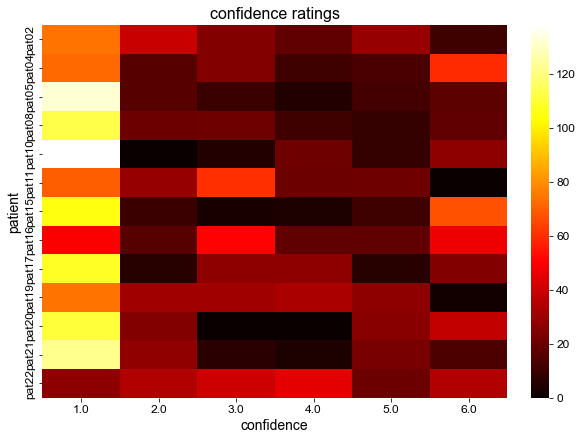

In [51]:
# count the number of times each 'patient' had each 'confidence' rating
confidence_counts = metadata.groupby(['patient', 'confidence']).size().unstack()
confidence_counts = confidence_counts.fillna(0)
confidence_counts = confidence_counts.astype(int).reset_index()

# plot the number of times each 'patient' had each 'confidence' rating
_, ax = plt.subplots(figsize=[8,6])
sns.heatmap(confidence_counts.set_index('patient'), cmap='hot', ax=ax)
ax.set_title("confidence ratings")
plt.show()



### Run regression
Regress behavior on spectral features
* Ordered/ordinal logistic regression (1-6 confidence rating)
* Binary logistic regression (binary remembered/forgotten)
* Binary logistic regression with cross-validation

#### Ordered logistic regression
regress behavior (confidence rating, 1-6) on spectral parameters 

In [ ]:
# # run ordered logistic regression for all channels in each trial condition

# features_x = ['exponent_diff', 'alpha_diff', 'gamma_diff']

# # create dataframe to store results (one row for each channel-material pair)
# df = pd.DataFrame(columns=['patient', 'material', 'chan_idx', 'exp_coef', 
#                            'alpha_coef', 'gamma_coef', 'exp_pval',
#                             'alpha_pval', 'gamma_pval', 'score'])

# # run logistic regression 
# for i_patient, patient in enumerate(PATIENTS):
#     print(f"patient {patient}")
#     channels = results.loc[results['patient']==patient, 'chan_idx'].unique()
#     for channel in channels:
#         for i_material, material in enumerate(['words', 'faces']):
#             try: # some patients/channels don't have data 
#                 res_i = results.loc[(results['patient']==patient) & \
#                                     (results['chan_idx']==channel) & \
#                                     (results['material']==material)]
#                 model, res, score = run_ordered_logit(res_i, features_x, 'confidence')
#                 df_i = pd.DataFrame({'patient' : patient,
#                                     'material' : material,
#                                     'chan_idx' : channel,
#                                     'exp_coef' : res.params[0],
#                                     'alpha_coef' : res.params[1],
#                                     'gamma_coef' : res.params[2],
#                                     'exp_pval' : res.pvalues[0],
#                                     'alpha_pval' : res.pvalues[1],
#                                     'gamma_pval' : res.pvalues[2],
#                                     'score' : score},
#                                     index=[0])
#                 df = pd.concat([df, df_i], axis=0)
#             except:
#                 pass

# df

In [32]:
# save/load results from above
# df.to_csv(fr"{PROJECT_PATH}\data\results\ordered_logit_scores.csv")
df = pd.read_csv(fr"{PROJECT_PATH}\data\results\ordered_logit_scores.csv", index_col=0)
df

,patient,material,channel,exp_coef,alpha_coef,gamma_coef,exp_pval,alpha_pval,gamma_pval,score
0,pat02,words,0,-0.384489,-0.491266,-0.010276,0.172939,0.086196,0.970024,0.500000
0,pat02,faces,0,-0.145568,0.166754,0.046720,0.579366,0.478319,0.829811,0.266667
0,pat02,words,1,0.027454,-0.683176,0.341751,0.915897,0.021069,0.199874,0.625000
0,pat02,faces,1,-0.431681,0.237878,0.044833,0.101093,0.314693,0.877249,0.352941
0,pat02,words,2,0.530972,-0.177129,0.116591,0.102828,0.419691,0.615029,0.631579
...,...,...,...,...,...,...,...,...,...,...
0,pat22,faces,50,-0.043111,-0.593438,0.248450,0.843657,0.009979,0.241704,0.222222
0,pat22,words,51,0.234410,-0.205739,-0.161767,0.303147,0.302749,0.487409,0.350000
0,pat22,faces,51,-0.026752,-0.360276,-0.167708,0.914796,0.165447,0.496124,0.166667
0,pat22,words,52,0.213471,-0.066240,0.028134,0.312547,0.773356,0.890001,0.450000


#### Logistic regression (binary)
regress behavior (binarized memory performance) on spectral parameters

In [37]:
# # run logistic regression for all channels in each trial condition

# features_x = ['exponent_diff', 'alpha_diff', 'gamma_diff']
# feature_y = 'recalled'

# # create dataframe to store results (one row for each channel-material pair)
# df = pd.DataFrame(columns=['patient', 'material', 'channel', 'exp_coef', 
#                            'alpha_coef', 'gamma_coef', 'score'])

# # run logistic regression 
# for i_patient, patient in enumerate(PATIENTS):
#     print(f"patient {patient}")
#     channels = results.loc[results['patient']==patient, 'channel'].unique()
#     for channel in channels:
#         for i_material, material in enumerate(['words', 'faces']):
#             try: # some patients/channels don't have data 
#                 res_i = results.loc[(results['patient']==patient) & \
#                                     (results['channel']==channel) & \
#                                     (results['material']==material)]
#                 model, score = run_logistic_regression(res_i, features_x, feature_y)
#                 df_i = pd.DataFrame({'patient' : patient,
#                                     'material' : material,
#                                     'channel' : channel,
#                                     'exp_coef' : model.params[1],
#                                     'alpha_coef' : model.params[2],
#                                     'gamma_coef' : model.params[3],
#                                     'exp_pval' : model.pvalues[1],
#                                     'alpha_pval' : model.pvalues[2],
#                                     'gamma_pval' : model.pvalues[3],
#                                     'score' : score},
#                                     index=[0])
#                 df = pd.concat([df, df_i], axis=0)
#             except:
#                 pass

# df

In [34]:
# save/load results from above
# df.to_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores.csv")
df = pd.read_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores.csv", index_col=0)
df

,patient,material,channel,exp_coef,alpha_coef,gamma_coef,score,exp_pval,alpha_pval,gamma_pval
0,pat02,words,0,0.226524,0.162739,-0.979279,0.750000,0.598146,0.692108,0.055774
0,pat02,faces,0,0.073670,0.177799,-0.359692,0.466667,0.825165,0.567532,0.236186
0,pat02,words,1,0.300161,0.621439,-0.426856,0.812500,0.539432,0.101980,0.283198
0,pat02,faces,1,0.150048,-0.061845,-0.009276,0.823529,0.637435,0.824598,0.975558
0,pat02,words,2,-0.211764,0.403301,-0.216347,0.842105,0.605813,0.250778,0.568541
...,...,...,...,...,...,...,...,...,...,...
0,pat22,faces,50,-0.020848,0.453042,-0.201265,0.500000,0.939380,0.083275,0.493119
0,pat22,words,51,-0.230662,0.234428,0.185954,0.500000,0.324058,0.326489,0.463250
0,pat22,faces,51,0.053532,0.088411,-0.114096,0.444444,0.845881,0.735518,0.678104
0,pat22,words,52,-0.321834,-0.038642,-0.015510,0.550000,0.181461,0.867714,0.950601


#### Logistic regression (binary) with cross-validation
regress behavior (binarized memory performance) on spectral parameters

In [57]:
# # run logistic regression for all channels in each trial condition

# features_x = ['exponent_diff', 'alpha_diff', 'gamma_diff']
# feature_y = 'recalled'

# # create dataframe to store results (one row for each channel-material pair)
# df = results.groupby(['patient', 'chan_idx', 'material']).count().reset_index()
# df = df[['patient', 'chan_idx', 'material']]
# df['score'] = np.nan 

# # run logistic regression 
# for i_patient, patient in enumerate(PATIENTS):
#     print(f"patient {patient}")
#     channels = results.loc[results['patient']==patient, 'chan_idx'].unique()
#     for channel in channels:
#         for i_material, material in enumerate(['words', 'faces']):
#             try: # some patients/channels don't have data
#                 res_i = results.loc[(results['patient']==patient) & \
#                                     (results['chan_idx']==channel) & \
#                                     (results['material']==material)]
#                 _, score = run_logistic_regression_cv(res_i, features_x, 
#                                                         feature_y)
#                 df_index = (df['patient']==patient) & (df['chan_idx']==channel) & (df['material']==material)
#                 df.loc[df_index, 'score'] = score
#             except:
#                 pass

# df

In [56]:
# save/load results
# df.to_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores_cv.csv")
df = pd.read_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores_cv.csv", index_col=0)
df

,patient,chan_idx,material,score
0,pat02,0,faces,0.666667
1,pat02,0,words,0.833333
2,pat02,1,faces,0.679412
3,pat02,1,words,0.837500
4,pat02,2,faces,0.618713
...,...,...,...,...
1338,pat22,50,words,0.473684
1339,pat22,51,faces,0.533987
1340,pat22,51,words,0.489474
1341,pat22,52,faces,0.593464


#### Logistic regression (binary) with cross-validation, and wieghted classes
regress behavior (binarized memory performance) on spectral parameters. Weight
classes based on frequency

In [59]:
# # run logistic regression for all channels in each trial condition

# features_x = ['exponent_diff', 'alpha_diff', 'gamma_diff']
# feature_y = 'recalled'

# # create dataframe to store results (one row for each channel-material pair)
# df = results.groupby(['patient', 'chan_idx', 'material']).count().reset_index()
# df = df[['patient', 'chan_idx', 'material']]
# df['score'] = np.nan 

# # run logistic regression 
# for i_patient, patient in enumerate(PATIENTS):
#     print(f"patient {patient}")
#     channels = results.loc[results['patient']==patient, 'chan_idx'].unique()
#     for channel in channels:
#         for i_material, material in enumerate(['words', 'faces']):
#             try: # some patients/channels don't have data
#                 res_i = results.loc[(results['patient']==patient) & \
#                                     (results['chan_idx']==channel) & \
#                                     (results['material']==material)]
#                 _, score = run_logistic_regression_cv(res_i, features_x, 
#                                                         feature_y, weight=True)
#                 df_index = (df['patient']==patient) & (df['chan_idx']==channel) & (df['material']==material)
#                 df.loc[df_index, 'score'] = score
#             except:
#                 pass

# df

In [8]:
# save/load results
# df.to_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores_weighted.csv")
df = pd.read_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores_weighted.csv", index_col=0)
df

,patient,chan_idx,material,score
0,pat02,0,faces,0.480000
1,pat02,0,words,0.500000
2,pat02,1,faces,0.492647
3,pat02,1,words,0.662500
4,pat02,2,faces,0.606433
...,...,...,...,...
1338,pat22,50,words,0.516316
1339,pat22,51,faces,0.430719
1340,pat22,51,words,0.500526
1341,pat22,52,faces,0.595425


### Plot regression results

In [65]:
# set chance level (0.5 for binary classification, 1/6 for 6-class classification)
chance = 0.5

In [66]:
# convert score to float
df['score'] = df['score'].astype(float)

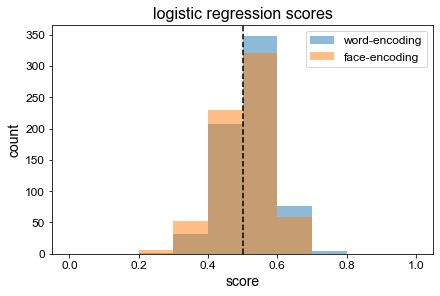

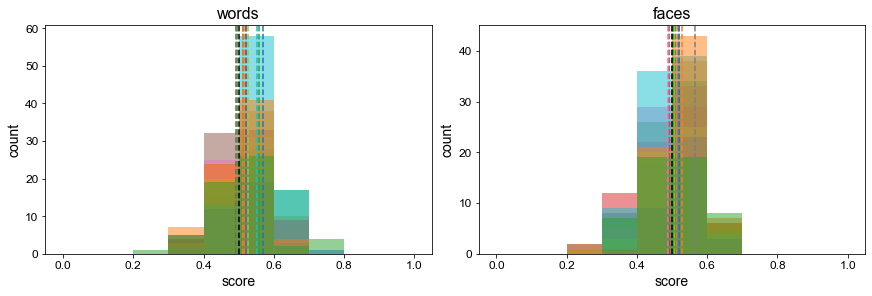

mean score:		 0.514

mean word score:	 0.520
median word score:	 0.526

mean face score:	 0.507
median face score:	 0.511


In [67]:
# plot score and print average scores
plot_score(df, chance=chance)

In [ ]:
# # plot histogram of coefficients

# # get those with scores above chance
# df_plt = df.loc[df['score']>(0.7)]
# # df_plt = df.copy()

# # plot
# all_values = df_plt[['exponent_coef', 'alpha_coef', 'gamma_coef']].values.flatten()
# bins = np.linspace(np.min(all_values), np.max(all_values), 30)
# _, ax = plt.subplots(1, 3, figsize=[12, 4], sharey=True, constrained_layout=True)
# for i, feature in enumerate(['exp_coef', 'alpha_coef', 'gamma_coef']):
#     ax[i].hist(df_plt[feature], bins, color=COLORS['blue'])
#     ax[i].set(xlabel=feature, ylabel='count')
#     ax[i].axvline(0, color='k', linestyle='--') 
# plt.show()


# # plot
# all_values = df_plt[['exponent_coef', 'alpha_coef', 'gamma_coef']].values.flatten()
# bins = np.linspace(np.min(all_values), np.max(all_values), 30)
# _, ax = plt.subplots(figsize=[6, 4])
# for i, feature in enumerate(['exp_coef', 'alpha_coef', 'gamma_coef']):
#     ax.hist(df_plt[feature], bins, alpha=0.5, label=feature)
# ax.axvline(0, color='k', linestyle='--')
# ax.set(xlabel='coefficient', ylabel='count')
# ax.legend()
# plt.show()


In [71]:
# # plot histogram of pvalues

# # get those with scores above chance
# # df_plt = df.loc[df['score']>(1/6)]
# df_plt = df.copy()

# # plot
# _, ax = plt.subplots(1, 3, figsize=[12, 4], sharey=True, constrained_layout=True)
# for i, feature in enumerate(['exp_pval', 'alpha_pval', 'gamma_pval']):
#     ax[i].hist(df_plt[feature])
#     ax[i].set(xlabel=feature, ylabel='count')
# plt.show()


### Analyze coefficients and p-values
Run stats and create figures for manuscript

In [ ]:
# run 1-smaple t-test to determine if coefficients are significantly different from 0

# print coefficients
print(f"Mean coefficients:")
print(f"exp:\t {df['exp_coef'].mean():0.5f}")
print(f"alpha:\t {df['alpha_coef'].mean():0.5f}")
print(f"gamma:\t {df['gamma_coef'].mean():0.5f}")

# run 1 sample t-test
print("\n\nT-test results:")
for ii in range(3):
    data_i = df.iloc[:,ii+3].to_numpy()
    t, p = ttest_1samp(data_i, 0)
    print(f"{df.columns[ii+3].split('_')[0]}:\t t={t:0.3f}, p={p:0.3f}")
    
# run 1 sample t-test for word-/face-encoding only
for material in ['words', 'faces']:
    print(f"\n\nT-test, {material}-encoding:")
    df_m = df.loc[df['material']==material] # subset dataframe
    for ii in range(3):
        data_i = df_m.iloc[:,ii+3]
        t, p = ttest_1samp(data_i, 0)
        print(f"{df.columns[ii+3].split('_')[0]}:\t t={t:0.3f}, p={p:0.3f}")

In [ ]:
# analyze coefficients for predictive channels only

def analyze_coef(df):
    """
    Evaluate whether logistic regression coefficients are significantly different
    than zero. Print results of 1-sample t-test.
    """

    for material in ['words', 'faces']:
        print(f"\nT-test, {material}-encoding:")
        for ii in range(3):
            df_m = df.loc[df['material']==material]
            data_i = df_m.iloc[:,ii+3]
            t, p = ttest_1samp(data_i, 0)
            print(f"{df.columns[ii+3].split('_')[0]}:\t t={t:0.5f}, p={p:0.5f}")

# test 
for threshold in np.linspace(0.1,0.9,9):
    print(f"\n\nThreshold = {threshold} ********************")
    df_i = df.loc[df['score'] > threshold]
    analyze_coef(df_i)

In [ ]:
# count number of signifcant coefficients for each feature
alpha = 0.05
for feature in ['exp', 'alpha', 'gamma']:
    n_sig = np.sum(df[f'{feature}_pval']<alpha)
    print(f"{feature}:\t{n_sig} ({n_sig/len(df)*100:0.2f}%)")


In [ ]:
# plot violin plot of regression scores

# set plotting params
plotting_params = {
    'data'  :   df,
    'x'     :   'material',
    'y'     :   'score',
}

# plot
_, ax = plt.subplots(figsize=[4,3])
sns.violinplot(**plotting_params, ax=ax, color=COLORS['blue'])
ax.axhline(chance, color='k', linestyle='--')

# add significance markers
for i_material, material in enumerate(['words', 'faces']):
# for i_material, material in enumerate(['words', 'faces']):
    data = df.loc[df['material']==material, 'score']
    data = data[~np.isnan(data)]
    t, p = ttest_1samp(data, chance)
    if p < 0.05:
        ax.text(i_material, np.max(df['score'])*1.15, '*', fontsize=12, ha='center', va='center')

    # print stats
    print(f"\nT-test, {material}-encoding:")
    print(f"t={t:0.3f}, p={p:0.3n}")

ax.set_ylim([np.min(df['score'])-np.min(df['score'])*0.3, np.max(df['score'])*1.3])
ax.set(ylabel='regression score')
plt.show()

#### plot score v. electrode coordinate

In [6]:
# fname = r"C:\Users\micha\projects\oscillation_vs_exponent\data\specparam_sensitivity_analysis\logit_scores\psd_trial_params_7.csv"
# df = pd.read_csv(fname, index_col=0)
# df = df.loc[df['ap_mode']=='knee'].drop(columns='ap_mode')
# df.rename(columns={'channel':'chan_idx'}, inplace=True)
# df

In [26]:
df_elec

,index,patient,chan_idx,label,pos_y,pos_x,pos_z
0,9,pat02,0,A01-A02,-65.43100,61.94490,3.55955
1,10,pat02,1,A02-A03,-70.93895,57.17765,12.15540
2,11,pat02,2,A03-A04,-75.39550,51.39440,20.94335
3,12,pat02,3,A04-A05,-78.91950,43.90980,30.13485
4,13,pat02,4,A05-A06,-80.96735,35.21485,38.13475
...,...,...,...,...,...,...,...
690,1385,pat22,48,MOF_03-MOF_04,36.00000,-14.00000,3.00000
691,1386,pat22,49,MOF_04-MOF_07,40.50000,-14.00000,9.50000
692,1387,pat22,50,MOF_07-MOF_08,44.50000,-14.00000,16.50000
693,1388,pat22,51,MOF_08-MOF_09,48.00000,-14.00000,23.50000


In [20]:
results

,patient,chan_idx,material,score
0,pat02,0,faces,0.480000
1,pat02,0,words,0.500000
2,pat02,1,faces,0.492647
3,pat02,1,words,0.662500
4,pat02,2,faces,0.606433
...,...,...,...,...
1338,pat22,50,words,0.516316
1339,pat22,51,faces,0.430719
1340,pat22,51,words,0.500526
1341,pat22,52,faces,0.595425


In [30]:
# load regression results from above
results = pd.read_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores_weighted.csv", index_col=0)

# load electrode locations
df_elec = pd.read_csv(f"{PROJECT_PATH}/data/ieeg_metadata/ieeg_channel_info.csv", index_col=0)
df_elec.drop(columns=['index', 'label'], inplace=True)

# merge channel info with regression results
df = pd.merge(results, df_elec, on=['patient', 'chan_idx'])
df

,patient,chan_idx,material,score,pos_y,pos_x,pos_z
0,pat02,0,faces,0.480000,-65.43100,61.94490,3.55955
1,pat02,0,words,0.500000,-65.43100,61.94490,3.55955
2,pat02,1,faces,0.492647,-70.93895,57.17765,12.15540
3,pat02,1,words,0.662500,-70.93895,57.17765,12.15540
4,pat02,2,faces,0.606433,-75.39550,51.39440,20.94335
...,...,...,...,...,...,...,...
1338,pat22,50,words,0.516316,44.50000,-14.00000,16.50000
1339,pat22,51,faces,0.430719,48.00000,-14.00000,23.50000
1340,pat22,51,words,0.500526,48.00000,-14.00000,23.50000
1341,pat22,52,faces,0.595425,52.00000,-14.00000,30.00000


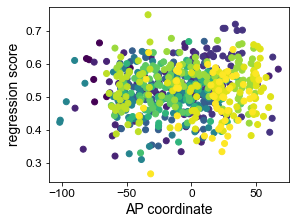

c:\Users\micha\anaconda3\envs\tilt_vs_fingerprint\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\micha\anaconda3\envs\tilt_vs_fingerprint\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\micha\anaconda3\envs\tilt_vs_fingerprint\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: score   
No. Observations: 668     Method:             REML    
No. Groups:       13      Scale:              0.0046  
Min. group size:  9       Log-Likelihood:     829.3791
Max. group size:  88      Converged:          Yes     
Mean group size:  51.4                                
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
const        0.522    0.006 84.706 0.000  0.510  0.534
pos_y        0.000    0.000  1.870 0.062 -0.000  0.000
Group Var    0.000    0.003                           

coef:	 0.00018223537093069555


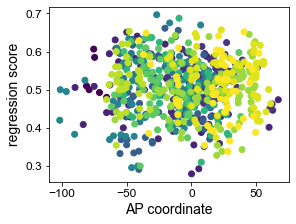

c:\Users\micha\anaconda3\envs\tilt_vs_fingerprint\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: score   
No. Observations: 667     Method:             REML    
No. Groups:       13      Scale:              0.0054  
Min. group size:  9       Log-Likelihood:     775.7906
Max. group size:  88      Converged:          Yes     
Mean group size:  51.3                                
------------------------------------------------------
           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------
const       0.508    0.004 113.618 0.000  0.499  0.517
pos_y      -0.000    0.000  -0.591 0.555 -0.000  0.000
Group Var   0.000    0.001                            

coef:	 -5.832807895814849e-05


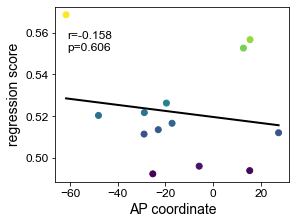

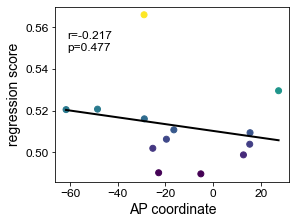

In [31]:
# compute correlation between score and position - LMM - color by patient
from statsmodels.regression.mixed_linear_model import MixedLM

for material in ['words', 'faces']:
    # drop NaN
    df_c = df.dropna()
    df_c = df_c.loc[df_c['material']==material]
    x_data = df_c['pos_y']
    y_data = df_c['score']

    # convert 'patient' for color plotting
    # take end of string and convert to int
    df_c['patient'] = df_c['patient'].str[3:].astype(int)
    color = df_c['patient']

    # plot data
    fig, ax = plt.subplots(figsize=[4,3])
    ax.scatter(x_data, y_data, c=color)
    ax.set(xlabel=f"AP coordinate", ylabel="regression score")
    plt.show()

    # run LMM
    model = MixedLM(y_data, sm.add_constant(x_data), df_c['patient'])
    results = model.fit()
    print(results.summary())

    # print coefficient for position
    print(f"coef:\t {results.params[1]}")


# Now, average scores within patient and re-run summary stats
df_avg = df.groupby(['patient', 'material']).mean().reset_index()

for material in ['words', 'faces']:
    # drop NaN
    df_c = df_avg.dropna()
    df_c = df_c.loc[df_c['material']==material]
    x_data = df_c['pos_y']
    y_data = df_c['score']

    # run regression
    stats = linregress(x_data, y_data)
    t_lin = np.linspace(np.nanmin(x_data), np.nanmax(x_data), 100)
    lin = stats.slope * t_lin + stats.intercept

    # plot results
    fig, ax = plt.subplots(figsize=[4,3])
    ax.scatter(x_data, y_data, c=y_data, cmap='viridis')
    ax.plot(t_lin, lin, color='k', linewidth=2)
    ax.text(0.05, 0.75, f"r={stats.rvalue:0.3f}\np={stats.pvalue:0.3f}",
            transform=ax.transAxes, backgroundcolor='w', fontsize=12)
    ax.set(xlabel=f"AP coordinate", ylabel="regression score")
    plt.show()
    


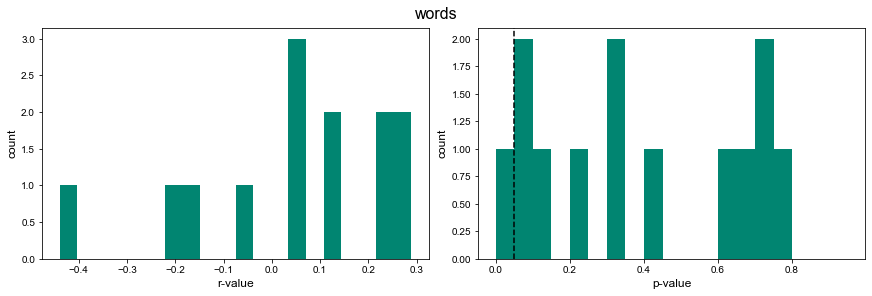

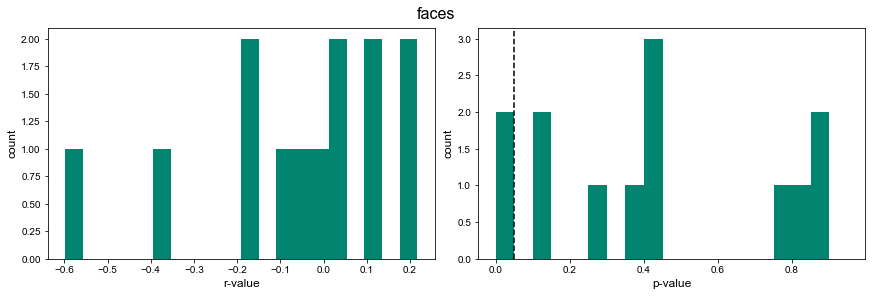

,patient,material,rvalue,pvalue
0,pat02,words,-0.192928,0.618957
1,pat02,faces,-0.067699,0.862611
2,pat04,words,0.256689,0.031951
3,pat04,faces,-0.179409,0.137252
4,pat05,words,0.125279,0.323949
5,pat05,faces,-0.022959,0.857093
6,pat08,words,0.038078,0.754312
7,pat08,faces,0.026991,0.824469
8,pat10,words,-0.439335,0.077656
9,pat10,faces,0.216298,0.404377


In [32]:
# model regression for each patient

df_list = []
for patient in PATIENTS:
    for material in ['words', 'faces']:
        # get data for patient/material and drop NaN
        df_m = df.loc[(df['material']==material) & (df['patient']==patient)]
        df_m = df_m.dropna()
        x_data = df_m['pos_y']
        y_data = df_m['score']

        # run regression
        stats = linregress(x_data, y_data)

        # aggregate results
        df_i = pd.DataFrame({'patient' : patient,
                            'material' : material,
                            'rvalue' : stats.rvalue,
                            'pvalue' : stats.pvalue},
                            index=[0])
        df_list.append(df_i)

# combine results
df_results = pd.concat(df_list).reset_index(drop=True)

# plot
p_bins = np.arange(0, 1, 0.05)
for material in ['words', 'faces']:
    df_m = df_results.loc[df_results['material']==material]
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[12,4])
    fig.suptitle(material, fontsize=16)
    ax0.hist(df_m['rvalue'], bins=20, color=COLORS['blue'])
    ax0.set_xlabel("r-value", fontsize=12)
    ax0.set_ylabel("count", fontsize=12)
    ax1.hist(df_m['pvalue'], bins=p_bins, color=COLORS['blue'])
    ax1.set_xlabel("p-value", fontsize=12)
    ax1.set_ylabel("count", fontsize=12)
    ax1.axvline(0.05, color='k', linestyle='--')
    for ax in [ax0, ax1]:
        ax.tick_params(axis='both', which='major', labelsize=10)
    plt.show()

# print results
df_results


In [33]:
from scipy.stats import ttest_1samp

# run 1-sample t-test for r-values
for material in ['words', 'faces']:
    df_m = df_results.loc[df_results['material']==material]
    t, p = ttest_1samp(df_m['rvalue'], 0)
    print(f"{material}:\t t={t:0.3f}, p={p:0.3f}")

# drop outliers and re-run
outlier_idx = [0, 8]
df_results_no = df_results.drop(outlier_idx)
print("\n\nAfter dropping outliers:")
for material in ['words', 'faces']:
    df_m = df_results_no.loc[df_results_no['material']==material]
    t, p = ttest_1samp(df_m['rvalue'], 0)
    print(f"{material}:\t t={t:0.3f}, p={p:0.3f}")

words:	 t=0.736, p=0.476
faces:	 t=-0.976, p=0.348


After dropping outliers:
words:	 t=2.527, p=0.030
faces:	 t=-0.976, p=0.348


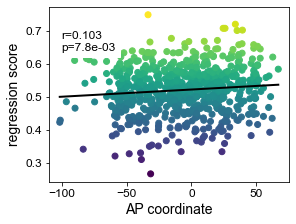

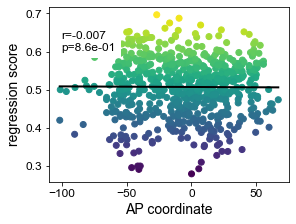

In [34]:
# compute correlation between score and position

for material in ['words', 'faces']:
    # drop NaN
    df_c = df.dropna()
    df_c = df_c.loc[df_c['material']==material]
    x_data = df_c['pos_y']
    y_data = df_c['score']

    # run regression and plot results
    stats = linregress(x_data, y_data)
    t_lin = np.linspace(np.nanmin(x_data), np.nanmax(x_data), 100)
    lin = stats.slope * t_lin + stats.intercept

    # plot
    fig, ax = plt.subplots(figsize=[4,3])
    ax.scatter(x_data, y_data, c=y_data, cmap='viridis')
    ax.plot(t_lin, lin, color='k', linewidth=2)
    ax.text(0.05, 0.75, f"r={stats.rvalue:0.3f}\np={stats.pvalue:0.1e}",
            transform=ax.transAxes, backgroundcolor='w', fontsize=12)
    ax.set(xlabel=f"AP coordinate", ylabel="regression score")
    plt.show()

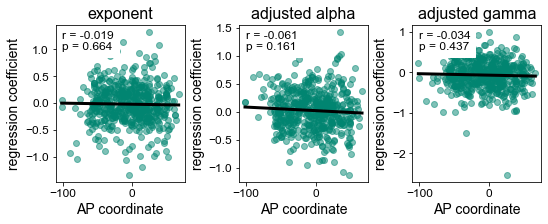

In [37]:
# compute correlation between coeeficient and position

material = 'words'

# load regression results (with coefficients - not cross-validated)
results = pd.read_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores.csv", index_col=0)
# results = pd.read_csv(fr"{PROJECT_PATH}\data\results\ordered_logit_scores.csv", index_col=0)
df_elec = pd.read_csv(f"{PROJECT_PATH}/data/ieeg_metadata/ieeg_channel_info.csv", index_col=0)
df_elec.drop(columns=['index'], inplace=True)
df_elec.rename(columns={'chan_idx':'channel'}, inplace=True)
df_plt = pd.merge(results, df_elec, on=['patient', 'channel'])

# get those with scores above chance
df_plt = df_plt.loc[df_plt['score']>(0.5)]

# drop NaN
df_c = df_plt.dropna()
df_c = df_c.loc[df_c['material']==material]
x_data = df_c['pos_y']

# create fig
fig, axes = plt.subplots(1, 3, figsize=[7.5, 3], constrained_layout=True)
titles = ['exponent', 'adjusted alpha', 'adjusted gamma']
for ax, feature, title in zip(axes, ['exp', 'alpha', 'gamma'], titles):
        y_data = df_c[f'{feature}_coef']

        # plot data
        ax.set_title(title)
        ax.scatter(x_data, y_data, color=COLORS['blue'], alpha=0.5)
        ax.set(xlabel=f"AP coordinate", ylabel="regression coefficient")

        # run regression and plot results
        stats = linregress(x_data, y_data)
        t_lin = np.linspace(np.nanmin(x_data), np.nanmax(x_data), 100)
        lin = stats.slope * t_lin + stats.intercept
        
        ax.plot(t_lin, lin, color='k', linewidth=3)
        if stats.pvalue > 0.01:
                ax.text(0.05, 0.84, f"r = {stats.rvalue:0.3f}\np = {stats.pvalue:0.3n}", 
                        transform=ax.transAxes, backgroundcolor='w', fontsize=12)
        else:
                ax.text(0.05, 0.84, f"r = {stats.rvalue:0.3f}\np = {stats.pvalue:0.1e}", 
                        transform=ax.transAxes, backgroundcolor='w', fontsize=12)

plt.show()

#### combine figures for manuscript

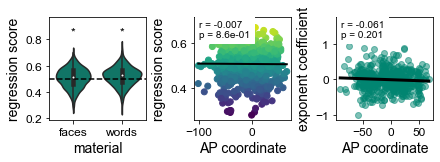

In [39]:
# manuscript figure

material = 'words'

chance = 0.5

# init
fig, (ax_b, ax_c, ax_d) = plt.subplots(1, 3, figsize=[6, 2], constrained_layout=True)

# B. plot violin plot of regression scores =====================================
# set plotting params
plotting_params = {
    'data'  :   df,
    'x'     :   'material',
    'y'     :   'score',
}

# plot
sns.violinplot(**plotting_params, ax=ax_b, color=COLORS['blue'])
ax_b.axhline(chance, color='k', linestyle='--')
ax_b.set_ylim([np.min(df['score'])-np.min(df['score'])*0.3, np.max(df['score'])*1.3])
ax_b.set(ylabel='regression score')

# add significance markers
for i_material, material in enumerate(['words', 'faces']):
    data = df.loc[df['material']==material, 'score']
    data = data[~np.isnan(data)]
    t, p = ttest_1samp(data, chance)
    if p < 0.05:
        ax_b.text(i_material, np.max(df['score'])*1.15, '*', fontsize=12, ha='center', va='center')

# C. scatter plot: correlate regresion score and AP coordinate =================

# drop NaN
df_c = df.dropna()
df_c = df_c.loc[df_c['material']==material]
x_data = df_c['pos_y']
y_data = df_c['score']

# plot data
ax_c.scatter(x_data, y_data, c=y_data, cmap='viridis')
ax_c.set(xlabel=f"AP coordinate", ylabel="regression score")

# run regression and plot results
stats = linregress(x_data, y_data)
t_lin = np.linspace(np.nanmin(x_data), np.nanmax(x_data), 100)
lin = stats.slope * t_lin + stats.intercept
ax_c.plot(t_lin, lin, color='k', linewidth=2)
ax_c.text(0.05, 0.8, f"r = {stats.rvalue:0.3f}\np = {stats.pvalue:0.1e}",
        transform=ax_c.transAxes, backgroundcolor='w')


# D. scatter plot: correlate exponent coeeficient and AP coordinate ============
# load regression results (with coefficients - not cross-validated)
results = pd.read_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores.csv", index_col=0)
results = results.loc[results['material']==material]
df_elec = pd.read_csv(f"{PROJECT_PATH}/data/ieeg_metadata/ieeg_channel_info.csv", index_col=0)
df_elec.drop(columns=['index'], inplace=True)
df_elec.rename(columns={'chan_idx':'channel'}, inplace=True)
df_plt = pd.merge(results, df_elec, on=['patient', 'channel'])

# get those with scores above chance
df_plt = df_plt.loc[df_plt['score']>(0.5)]

# drop NaN
df_c = df_plt.dropna()
x_data = df_c['pos_y']
y_data = df_c['exp_coef']

# plot data
ax_d.scatter(x_data, y_data, color=COLORS['blue'], alpha=0.5)
ax_d.set(xlabel=f"AP coordinate", ylabel="exponent coefficient")

# run regression and plot results
stats = linregress(x_data, y_data)
t_lin = np.linspace(np.nanmin(x_data), np.nanmax(x_data), 100)
lin = stats.slope * t_lin + stats.intercept
ax_d.plot(t_lin, lin, color='k', linewidth=3)
if stats.pvalue > 0.01:
        ax_d.text(0.05, 0.8, f"r = {stats.rvalue:0.3f}\np = {stats.pvalue:0.3n}", 
                transform=ax_d.transAxes, backgroundcolor='w')
else:
        ax_d.text(0.05, 0.8, f"r = {stats.rvalue:0.3f}\np = {stats.pvalue:0.1e}", 
                transform=ax_d.transAxes, backgroundcolor='w')

# save fig
# plt.savefig(f"{PROJECT_PATH}/figures/main_figures/model_behavior_bcd.png")


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



T-test, words-encoding:
mean score:	0.520
t=7.383, p=4.6e-13

T-test, faces-encoding:
mean score:	0.507
t=2.518, p=1.2e-02


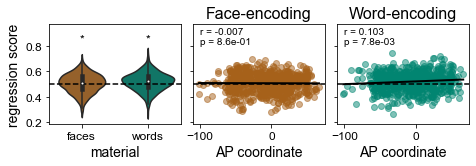

In [ ]:
# manuscript figure

# init
fig, (ax_b, ax_c, ax_d) = plt.subplots(1, 3, figsize=[6.5, 2.2], sharey=True,
                                 constrained_layout=True)


# B. plot violin plot of regression scores =====================================
# set plotting params
plotting_params = {
    'data'  :   df,
    'x'     :   'material',
    'y'     :   'score',
}

# plot
sns.violinplot(**plotting_params, ax=ax_b, palette=[COLORS['brown'], COLORS['blue']])
ax_b.set_ylim([np.min(df['score'])-np.min(df['score'])*0.3, np.max(df['score'])*1.3])
ax_b.set(ylabel='regression score')

# add significance markers
for i_material, material in enumerate(['words', 'faces']):
    data = df.loc[df['material']==material, 'score']
    data = data[~np.isnan(data)]
    t, p = ttest_1samp(data, chance)
    if p < 0.05:
        ax_b.text(i_material, np.max(df['score'])*1.15, '*', fontsize=12, ha='center', va='center')

    # print stats
    print(f"\nT-test, {material}-encoding:")
    print(f"mean score:\t{np.nanmean(data):0.3f}")
    print(f"t={t:0.3f}, p={p:0.1e}")

# C. scatter plot: correlate regresion score and AP coordinate =================

# drop NaN
df_c = df.dropna()
df_c = df_c.loc[df_c['material']=='faces']
x_data = df_c['pos_y']
y_data = df_c['score']

# plot data
ax_c.scatter(x_data, y_data, c=COLORS['brown'], alpha=0.5)
ax_c.set(xlabel=f"AP coordinate")#, ylabel="regression score")
ax_c.set_title("Face-encoding")

# run regression and plot results
stats = linregress(x_data, y_data)
t_lin = np.linspace(np.nanmin(x_data), np.nanmax(x_data), 100)
lin = stats.slope * t_lin + stats.intercept
ax_c.plot(t_lin, lin, color='k', linewidth=2)
ax_c.text(0.05, 0.8, f"r = {stats.rvalue:0.3f}\np = {stats.pvalue:0.1e}",
        transform=ax_c.transAxes)

# D. scatter plot: correlate regresion score and AP coordinate =================

# drop NaN
df_c = df.dropna()
df_c = df_c.loc[df_c['material']=='words']
x_data = df_c['pos_y']
y_data = df_c['score']

# plot data
ax_d.scatter(x_data, y_data, c=COLORS['blue'], alpha=0.5)
ax_d.set(xlabel=f"AP coordinate")#, ylabel="regression score")
ax_d.set_title("Word-encoding")

# run regression and plot results
stats = linregress(x_data, y_data)
t_lin = np.linspace(np.nanmin(x_data), np.nanmax(x_data), 100)
lin = stats.slope * t_lin + stats.intercept
ax_d.plot(t_lin, lin, color='k', linewidth=2)
ax_d.text(0.05, 0.8, f"r = {stats.rvalue:0.3f}\np = {stats.pvalue:0.1e}",
        transform=ax_d.transAxes)

# add chance line
for ax in [ax_b, ax_c, ax_d]:
    ax.axhline(chance, color='k', linestyle='--')

# save fig
plt.savefig(f"{PROJECT_PATH}/figures/behavioral_modeling/scores.png")


### Intersection frequency analysis

In [36]:
# load data from above
results_in = pd.read_csv(f"{PROJECT_PATH}/data/results/df_behavior_model.csv")
results_in

,patient,material,memory,chan_idx,trial,ap_mode,exponent_diff,alpha_diff,alpha_adj_diff,gamma_diff,gamma_adj_diff,trial_num,pleasantness,confidence,recalled,reaction_time
0,pat02,faces,hit,0,0,knee,-0.280652,-0.855951,-0.684832,0.179730,0.029159,2.0,4.0,3.0,1.0,1780.1
1,pat02,faces,hit,1,0,knee,-0.623515,-0.775621,-0.271137,0.088607,0.010413,2.0,4.0,3.0,1.0,1780.1
2,pat02,faces,hit,2,0,knee,0.355443,-0.376352,-0.147762,0.280228,-0.027953,2.0,4.0,3.0,1.0,1780.1
3,pat02,faces,hit,3,0,knee,0.392906,-0.322657,-0.300127,0.175404,-0.346786,2.0,4.0,3.0,1.0,1780.1
4,pat02,faces,hit,4,0,knee,0.035045,-0.011587,0.217569,-0.155675,0.015464,2.0,4.0,3.0,1.0,1780.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120116,pat22,words,miss,48,13,knee,-0.177758,0.348087,0.089181,0.299301,0.029722,15.0,4.0,3.0,1.0,4546.7
120117,pat22,words,miss,49,13,knee,-0.175726,-0.574301,-0.902624,-0.176918,-0.741822,15.0,4.0,3.0,1.0,4546.7
120118,pat22,words,miss,50,13,knee,0.387098,-0.331536,-0.040596,0.178061,0.115366,15.0,4.0,3.0,1.0,4546.7
120119,pat22,words,miss,51,13,knee,-0.807495,0.135296,0.176582,0.082981,-0.129146,15.0,4.0,3.0,1.0,4546.7


In [38]:
# load intersection frequency results

df_if = pd.read_csv(f"{PROJECT_PATH}/data/results/trial_intersection_results.csv")
df_if.rename(columns={'i_trial':'trial'}, inplace=True)
df_if

,patient,chan_idx,material,memory,ap_mode,trial,intersection,intersection_idx
0,pat02,0,words,hit,knee,0,NaN,NaN
1,pat02,1,words,hit,knee,0,65.871345,61.0
2,pat02,2,words,hit,knee,0,NaN,NaN
3,pat02,3,words,hit,knee,0,NaN,NaN
4,pat02,4,words,hit,knee,0,NaN,NaN
...,...,...,...,...,...,...,...,...
52289,pat11,63,faces,hit,knee,43,NaN,NaN
52290,pat11,64,faces,hit,knee,43,NaN,NaN
52291,pat11,65,faces,hit,knee,43,65.871345,61.0
52292,pat11,66,faces,hit,knee,43,7.984405,3.0


In [42]:
# merge results and drop NaN (channels without intersection)
results = results_in.merge(df_if, on=['patient', 'chan_idx', 'material', 'memory', 'trial', 'ap_mode'])
results = results.dropna(subset=['intersection'])
results

,patient,material,memory,chan_idx,trial,ap_mode,exponent_diff,alpha_diff,alpha_adj_diff,gamma_diff,gamma_adj_diff,trial_num,pleasantness,confidence,recalled,reaction_time,intersection,intersection_idx
0,pat02,faces,hit,0,0,knee,-0.280652,-0.855951,-0.684832,0.179730,0.029159,2.0,4.0,3.0,1.0,1780.1,22.955166,18.0
1,pat02,faces,hit,1,0,knee,-0.623515,-0.775621,-0.271137,0.088607,0.010413,2.0,4.0,3.0,1.0,1780.1,51.898635,47.0
2,pat02,faces,hit,2,0,knee,0.355443,-0.376352,-0.147762,0.280228,-0.027953,2.0,4.0,3.0,1.0,1780.1,13.972710,9.0
3,pat02,faces,hit,3,0,knee,0.392906,-0.322657,-0.300127,0.175404,-0.346786,2.0,4.0,3.0,1.0,1780.1,9.980507,5.0
7,pat02,faces,hit,7,0,knee,-0.312656,0.322479,0.176666,-0.022767,0.092629,2.0,4.0,3.0,1.0,1780.1,27.945419,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40940,pat11,faces,hit,62,30,knee,-1.074871,-0.388185,0.748280,-0.061327,0.548227,32.0,3.0,1.0,1.0,2417.2,6.986355,2.0
40942,pat11,faces,hit,64,30,knee,0.193465,-0.872650,-0.976069,-0.166219,-0.005390,32.0,3.0,1.0,1.0,2417.2,17.964912,13.0
40943,pat11,faces,hit,65,30,knee,0.927551,0.180528,-0.434124,0.080820,0.136958,32.0,3.0,1.0,1.0,2417.2,59.883041,55.0
40944,pat11,faces,hit,66,30,knee,0.349333,-0.270265,-0.407649,-0.257383,-0.156120,32.0,3.0,1.0,1.0,2417.2,34.931774,30.0


In [46]:
# # run logistic regression

# features_x = ['exponent_diff', 'alpha_diff', 'gamma_diff']
# feature_y = 'recalled'

# # create dataframe to store results (one row for each channel-material pair)
# df = results.groupby(['patient', 'chan_idx', 'material']).count().reset_index()
# df = df[['patient', 'chan_idx', 'material']]
# df['score'] = np.nan 

# # run logistic regression 
# for i_patient, patient in enumerate(PATIENTS):
#     print(f"patient {patient}")
#     channels = results.loc[results['patient']==patient, 'chan_idx'].unique()
#     for channel in channels:
#         for i_material, material in enumerate(['words', 'faces']):
#             try: # some patients/channels don't have data
#                 res_i = results.loc[(results['patient']==patient) & \
#                                     (results['chan_idx']==channel) & \
#                                     (results['material']==material)]
#                 _, score = run_logistic_regression_cv(res_i, features_x, 
#                                                         feature_y, weight=True)
#                 df_index = (df['patient']==patient) & (df['chan_idx']==channel) & (df['material']==material)
#                 df.loc[df_index, 'score'] = score
#             except:
#                 pass

# df

In [ ]:
# save/load results
# df.to_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores_intersection.csv")
df = pd.read_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores_intersection.csv", index_col=0)
df

,patient,chan_idx,material,score
0,pat02,0,faces,0.600000
1,pat02,0,words,0.792857
2,pat02,1,faces,0.600000
3,pat02,1,words,0.557143
4,pat02,2,faces,0.525000
...,...,...,...,...
527,pat11,63,faces,0.533333
528,pat11,64,faces,0.400000
529,pat11,65,faces,0.700000
530,pat11,66,faces,0.550000


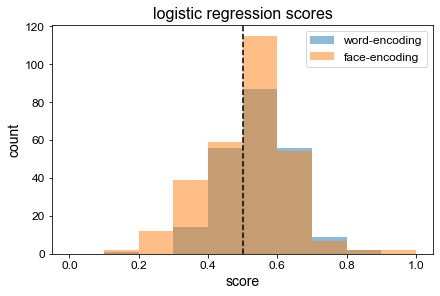

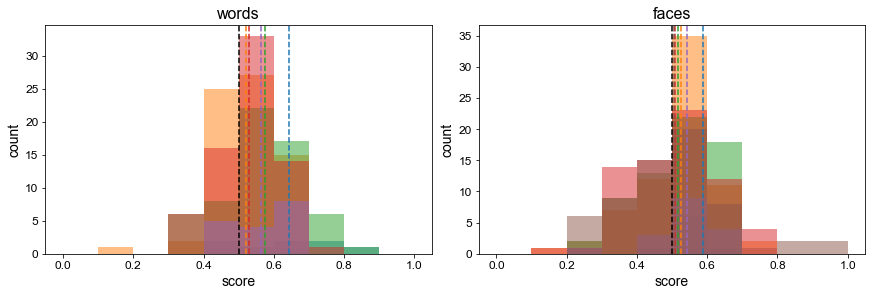

mean score:		 0.530

mean word score:	 0.545
median word score:	 0.550

mean face score:	 0.517
median face score:	 0.533


In [49]:
# plot scores
plot_score(df)